In [223]:
# Read all the text book
words = open('names.txt', 'r').read().split()
len(words)

32033

In [224]:
# Build a voculabory of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
len(chars)

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['~']= 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(f'vocab_size ; {vocab_size}  |\n stoi: {stoi}  | \n  itos: {itos}')

vocab_size ; 27  |
 stoi: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '~': 0}  | 
  itos: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '~'}


In [225]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device='cpu'
device

'cpu'

In [226]:
#build the dataset
block_size = 32  # context length

def build_datasets(words):    
    X,Y =[],[]
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '~':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), "---->", itos[ix])
            context = context[1:] + [ix]
    # stoi['~']
    # itos
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    print(f'X.shape : {X.shape} | Y.shape : {Y.shape}')
    return X,Y


import random
random.seed(42)
# random.shuffle(words) no shuffler required. Hence commented
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
print(f'total words : {len(words)} | training size  : {n1}  | validation size  : {n2}')
Xtr, Ytr = build_datasets(words[:n1])
Xv, Yv  = build_datasets(words[n1:n2])
Xte, Yt = build_datasets(words[n2:])

total words : 32033 | training size  : 25626  | validation size  : 28829
X.shape : torch.Size([182778, 32]) | Y.shape : torch.Size([182778])
X.shape : torch.Size([22633, 32]) | Y.shape : torch.Size([22633])
X.shape : torch.Size([22735, 32]) | Y.shape : torch.Size([22735])


In [239]:
## Lets train a deeper Network
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

g = torch.cuda.manual_seed(41)

class Linear:
    
    def __init__(self, fan_in, fan_out, device ='cpu', bias =True):
        self.weights = torch.randn((fan_in,fan_out), device = device, generator=g)/ fan_in**0.5
        self.bias = torch.zeros((fan_out), device= device) if bias else None
    
    def __call__(self, X):
        self.out = X @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum =0.1, device = 'cpu'):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.device = device
        
        #Parameter trained with backprop
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        
        # Buffers training with 'Momentum update'
        self.running_mean = torch.zeros(dim, device=device)
        self.running_var = torch.ones(dim, device=device)
    
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0,keepdim=True)  # batch mean
            xvar = x.var(0, keepdim=True, unbiased =True) # batch variance
        else:
            xmean= self.running_mean
            xvar= self.running_var
        
        xhat  = (x-xmean)/ torch.sqrt(xvar +self.eps)  # normalize to uniot variance
        self.out = self.gamma * xhat + self.beta
        
        #update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1- self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1- self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

#mlp revisited
n_embd = 10  # The dimensions of the character embeding vectors
n_hidden = 100 # No of neuron in hidden layer of the MLP
# block_size= 32
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
# g = torch.cuda.manual_seed(42)
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), device=device, generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(         n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    # Linear(         n_hidden, n_hidden), Tanh(),
    # Linear(         n_hidden, n_hidden), Tanh(),
    # Linear(         n_hidden, n_hidden), Tanh(),
    # Linear(         n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer : makes less confident
    # layers[-1].weights *= 0.1
    # all other layer apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weights *=  1 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement()  for p in parameters)) # number of parameter in Model

for p in parameters:
    p.requires_grad = True

76551


In [240]:
## optimization steps
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # print(f'Xtr : {Xtr.shape} | batch_size : {batch_size}')
    ix = torch.randint(0,Xtr.shape[0], (batch_size,), generator=g)
    Xb,Yb = Xtr[ix], Ytr[ix]  # batch X,Y
    
    # forward pass
    emb = C[Xb]  # embed the characters into vectors
    # print(f'emb : {emb.shape}')
    x = emb.view(emb.shape[0], -1) # concatinate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) #loss function  
    
    #backword pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out reayin graph
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update weight
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track status
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}  : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).item() for p in parameters])
    if i > 1000:
        break  # remove this after debug for full optimization

      0/ 200000  : 3.5809


layer 2 (      Tanh) : mean -0.00, std 0.64, staurated : 2.50%
layer 5 (      Tanh) : mean -0.00, std 0.66, staurated : 1.28%
layer 8 (      Tanh) : mean -0.01, std 0.67, staurated : 0.56%
layer 11 (      Tanh) : mean +0.00, std 0.67, staurated : 0.44%
layer 14 (      Tanh) : mean -0.00, std 0.67, staurated : 0.72%


Text(0.5, 1.0, 'Activation distributiuon')

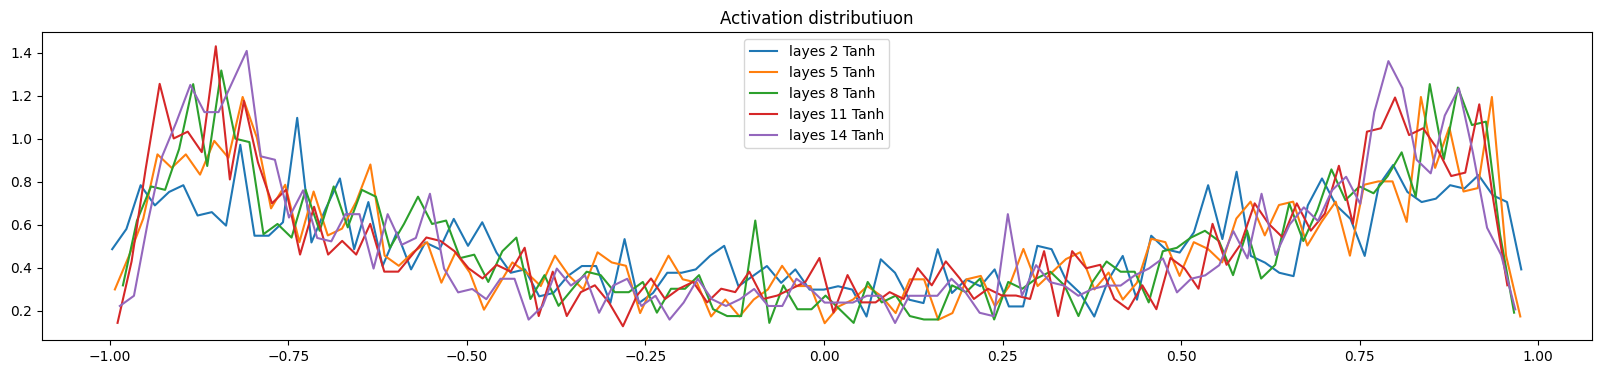

In [241]:
##Visuallize histograms
plt.figure(figsize=(20,4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s) : mean %+.2f, std %.2f, staurated : %.2f%%' % (i,layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layes {i} {layer.__class__.__name__}')
plt.legend(legends)
plt.title('Activation distributiuon')
    

layer 2 (      Tanh) : mean +0.00, std 0.00
layer 5 (      Tanh) : mean +0.00, std 0.00
layer 8 (      Tanh) : mean -0.00, std 0.00
layer 11 (      Tanh) : mean +0.00, std 0.00
layer 14 (      Tanh) : mean +0.00, std 0.00


Text(0.5, 1.0, 'Gradient distributiuon')

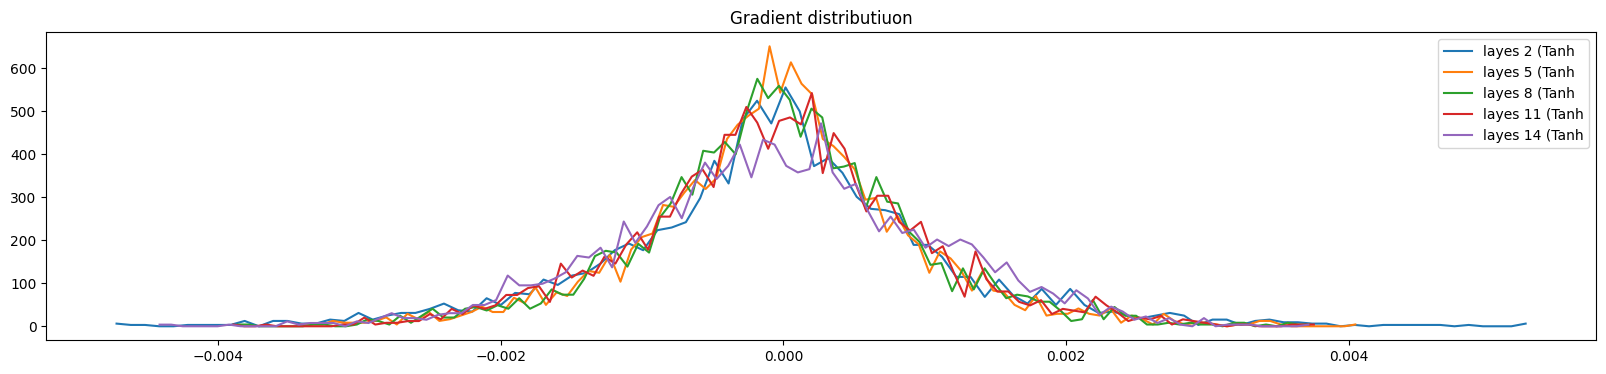

In [245]:
##Visuallize
plt.figure(figsize=(20,4)) # width and height of plot
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s) : mean %+.2f, std %.2f' % (i,layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layes {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('Gradient distributiuon')

25
weight   (27, 10) | mean -0.000000 | std 5.879625e-03 | grad:data 5.874180e-03
weight (320, 100) | mean -0.000016 | std 3.455770e-03 | grad:data 1.444510e-01
weight (100, 100) | mean +0.000088 | std 5.208227e-03 | grad:data 1.632542e-01
weight (100, 100) | mean +0.000055 | std 4.705471e-03 | grad:data 1.606562e-01
weight (100, 100) | mean -0.000018 | std 4.913523e-03 | grad:data 1.732664e-01
weight (100, 100) | mean -0.000027 | std 4.770312e-03 | grad:data 1.696566e-01
weight  (100, 27) | mean -0.000001 | std 1.313105e-02 | grad:data 2.550775e-01


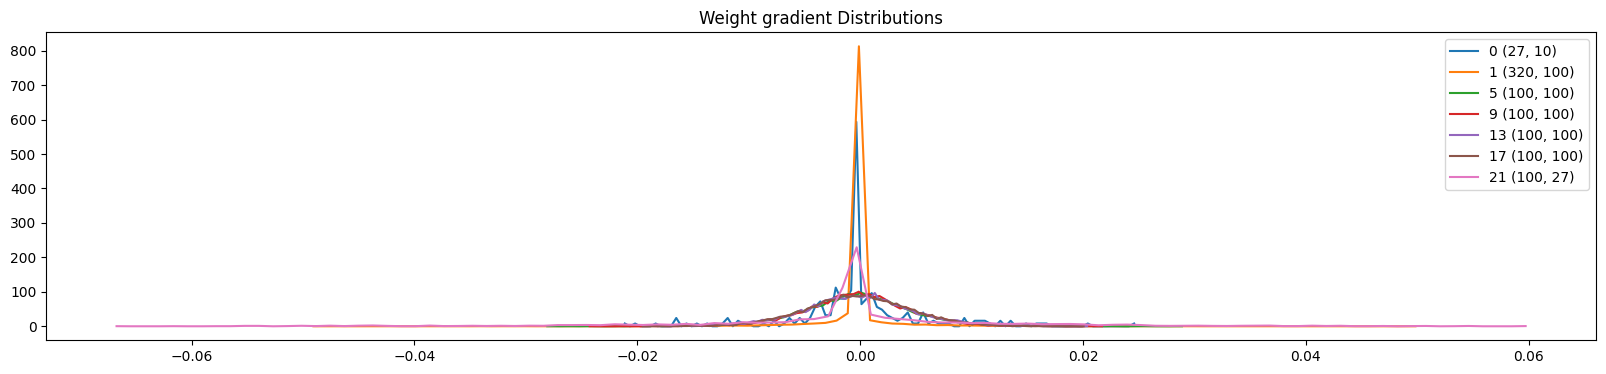

In [243]:
## Visualizations Histograms
plt.figure(figsize=(20,4))
legends = []
print(len(parameters))
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data %e' %(tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title("Weight gradient Distributions")
    

Text(0.5, 1.0, ' Idea for variations')

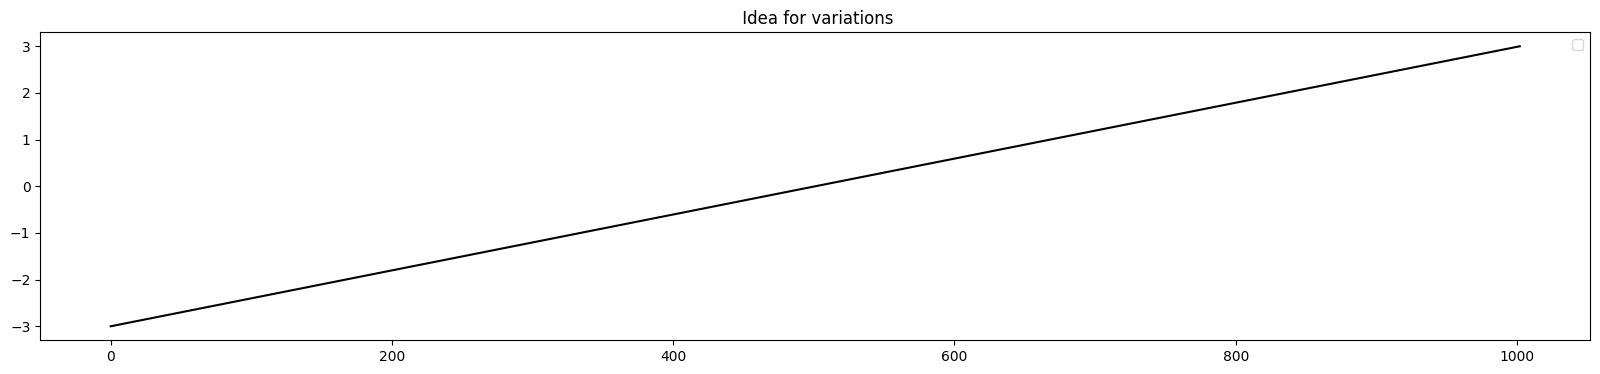

In [246]:
plt.figure(figsize=(20,4))
legends = []
for i,p in enumerate(parameters):
    if p.dim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0,len(ud)], [-3,3], 'k') # these rations should be ~le-3, indicate on plot
plt.legend(legends)
plt.title(" Idea for variations")